<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setting" data-toc-modified-id="Setting-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setting</a></span><ul class="toc-item"><li><span><a href="#Path" data-toc-modified-id="Path-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Path</a></span></li></ul></li><li><span><a href="#時系列データ作成" data-toc-modified-id="時系列データ作成-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>時系列データ作成</a></span></li><li><span><a href="#入力データ作成" data-toc-modified-id="入力データ作成-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>入力データ作成</a></span></li><li><span><a href="#Load-Model" data-toc-modified-id="Load-Model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Load Model</a></span></li><li><span><a href="#Visualize-conv1d_1-Outputs" data-toc-modified-id="Visualize-conv1d_1-Outputs-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Visualize conv1d_1 Outputs</a></span><ul class="toc-item"><li><span><a href="#Ch00-[0-59]" data-toc-modified-id="Ch00-[0-59]-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Ch00 [0-59]</a></span><ul class="toc-item"><li><span><a href="#plot" data-toc-modified-id="plot-5.1.1"><span class="toc-item-num">5.1.1&nbsp;&nbsp;</span>plot</a></span></li><li><span><a href="#Convolve-Output" data-toc-modified-id="Convolve-Output-5.1.2"><span class="toc-item-num">5.1.2&nbsp;&nbsp;</span>Convolve Output</a></span></li><li><span><a href="#plot" data-toc-modified-id="plot-5.1.3"><span class="toc-item-num">5.1.3&nbsp;&nbsp;</span>plot</a></span></li><li><span><a href="#元波形との重ねあわせ" data-toc-modified-id="元波形との重ねあわせ-5.1.4"><span class="toc-item-num">5.1.4&nbsp;&nbsp;</span>元波形との重ねあわせ</a></span><ul class="toc-item"><li><span><a href="#考察" data-toc-modified-id="考察-5.1.4.1"><span class="toc-item-num">5.1.4.1&nbsp;&nbsp;</span>考察</a></span></li></ul></li></ul></li><li><span><a href="#All-Ch-[0-59]" data-toc-modified-id="All-Ch-[0-59]-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>All Ch [0-59]</a></span><ul class="toc-item"><li><span><a href="#plot" data-toc-modified-id="plot-5.2.1"><span class="toc-item-num">5.2.1&nbsp;&nbsp;</span>plot</a></span></li><li><span><a href="#元波形との重ねあわせ" data-toc-modified-id="元波形との重ねあわせ-5.2.2"><span class="toc-item-num">5.2.2&nbsp;&nbsp;</span>元波形との重ねあわせ</a></span><ul class="toc-item"><li><span><a href="#考察" data-toc-modified-id="考察-5.2.2.1"><span class="toc-item-num">5.2.2.1&nbsp;&nbsp;</span>考察</a></span></li></ul></li></ul></li></ul></li><li><span><a href="#特徴をつかむ" data-toc-modified-id="特徴をつかむ-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>特徴をつかむ</a></span><ul class="toc-item"><li><span><a href="#波形の上昇を取得-(Ch29-[0-59])" data-toc-modified-id="波形の上昇を取得-(Ch29-[0-59])-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>波形の上昇を取得 (Ch29 [0-59])</a></span><ul class="toc-item"><li><span><a href="#plot" data-toc-modified-id="plot-6.1.1"><span class="toc-item-num">6.1.1&nbsp;&nbsp;</span>plot</a></span></li><li><span><a href="#Convolve-Output" data-toc-modified-id="Convolve-Output-6.1.2"><span class="toc-item-num">6.1.2&nbsp;&nbsp;</span>Convolve Output</a></span></li><li><span><a href="#plot" data-toc-modified-id="plot-6.1.3"><span class="toc-item-num">6.1.3&nbsp;&nbsp;</span>plot</a></span></li><li><span><a href="#元波形との重ねあわせ" data-toc-modified-id="元波形との重ねあわせ-6.1.4"><span class="toc-item-num">6.1.4&nbsp;&nbsp;</span>元波形との重ねあわせ</a></span><ul class="toc-item"><li><span><a href="#考察" data-toc-modified-id="考察-6.1.4.1"><span class="toc-item-num">6.1.4.1&nbsp;&nbsp;</span>考察</a></span></li></ul></li></ul></li><li><span><a href="#波形の下降を取得-(Ch32-[0-59])" data-toc-modified-id="波形の下降を取得-(Ch32-[0-59])-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>波形の下降を取得 (Ch32 [0-59])</a></span><ul class="toc-item"><li><span><a href="#plot" data-toc-modified-id="plot-6.2.1"><span class="toc-item-num">6.2.1&nbsp;&nbsp;</span>plot</a></span></li><li><span><a href="#Convolve-Output" data-toc-modified-id="Convolve-Output-6.2.2"><span class="toc-item-num">6.2.2&nbsp;&nbsp;</span>Convolve Output</a></span></li><li><span><a href="#plot" data-toc-modified-id="plot-6.2.3"><span class="toc-item-num">6.2.3&nbsp;&nbsp;</span>plot</a></span></li><li><span><a href="#元波形との重ねあわせ" data-toc-modified-id="元波形との重ねあわせ-6.2.4"><span class="toc-item-num">6.2.4&nbsp;&nbsp;</span>元波形との重ねあわせ</a></span><ul class="toc-item"><li><span><a href="#考察" data-toc-modified-id="考察-6.2.4.1"><span class="toc-item-num">6.2.4.1&nbsp;&nbsp;</span>考察</a></span></li></ul></li></ul></li></ul></li><li><span><a href="#End" data-toc-modified-id="End-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>End</a></span></li></ul></div>

# 一次元データ_Conv1d_重み可視化__sinFunc.ipynb

0. データ作成
  - 単なるsin関数を含んだ式
  - ノイズを加える
  - 異常波形作成
0. CNN時系列予測
  - [時系列予測を一次元畳み込みを使って解く with Keras - Qiita
      ](https://qiita.com/niisan-tokyo/items/a94dbd3134219f19cab1)
  - その背景を $windowsize$ 5-60程度で予測するConv1d層の作成
0. LSTMによる異常検出？
  - Conv1dで畳み込んだあとでLSTM層にぶち込めばよい？
  - LSTM層では異常かそうでないかの判別
    - 簡単にするために $\textbf{正常}:\textbf{異常}=1:1$ とするのが良さそう

In [90]:
ipynb_title = "visualize_Conv1d_model__SinCosFunc"

In [91]:
import os,sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pathlib import Path

import keras
print("Keras version : ", keras.__version__)

Keras version :  2.1.6


## Setting

### Path

In [92]:
HOME = Path(os.getcwd()).parent
print(HOME)

/home/pollen/workdir/git/github/article_script/20180719_visualize_Conv1d_output__in_kabuku


In [93]:
path_list = []
keras_model_h5_Path = HOME / "keras_model_h5_Path"
path_list.append(keras_model_h5_Path)
data_Path = HOME / "data"
path_list.append(data_Path)
plot_images_Path = data_Path / "plot_images"
path_list.append(plot_images_Path)

for _Path in path_list:
    _path = str(_Path)
    if not os.path.exists(_path):
        os.makedirs(name=_path)
        print("make a directory: \n\t", _path)
    else:
        print(os.path.exists(_path), ": ", _path)

True :  /home/pollen/workdir/git/github/article_script/20180719_visualize_Conv1d_output__in_kabuku/keras_model_h5_Path
True :  /home/pollen/workdir/git/github/article_script/20180719_visualize_Conv1d_output__in_kabuku/data
True :  /home/pollen/workdir/git/github/article_script/20180719_visualize_Conv1d_output__in_kabuku/data/plot_images


## 時系列データ作成

$$
\textbf{toy_func(t)} = 
  20 \cdot \left( 
    \sin\left( \frac{2\pi}{T} t \right)
    + \cos\left( 2 \cdot \frac{2\pi}{T} t \right)
    + \sin\left( 3 \cdot \frac{2\pi}{T} t \right)
    + \cos\left( 4 \cdot \frac{2\pi}{T} t \right)
  \right)
  + \frac{1}{5} t
  + \varepsilon
$$

In [94]:
def mySin(t, period=100):
    """
    時刻t, 周期period
    """
    return np.sin(2.0 * np.pi * t/period)

def myCos(t, period=100):
    """
    時刻t, 周期period
    """
    return np.cos(2.0 * np.pi * t/period)

In [95]:
# Add Noise
def toy_func(tStart=0, tStop=100, tStep=1, triAmpl=20, tAmpl=0.5, noiseAmpl=0.05):
    """
    T : 
      sin波の周期
    ampl : 
      ノイズ振幅調整
      """
    t = np.arange(start=tStart, stop=tStop, step=tStep)
    noise = np.random.randn(t.shape[0])  # mean=0, standard_deviation=1
    return (t,
            triAmpl * ( mySin(t, period=100)
                        + mySin(t=3*t, period=100)
                        + myCos(t=2*t, period=100)
                        + myCos(t=4*t, period=100) )
            + tAmpl * t
            + noiseAmpl * noise )

## 入力データ作成

In [96]:
windowsize = 60
predictsize = 1

$$
\textbf{toyfunc(t)} = 
  \frac{1}{4} \cdot \left( 
    \sin\left( \frac{2\pi}{T} t \right) + \cos\left( 2 \cdot \frac{2\pi}{T} t \right) + \sin\left( 3 \cdot \frac{2\pi}{T} t \right) + \cos\left( 4 \cdot \frac{2\pi}{T} t \right) \right)
  + \varepsilon
$$

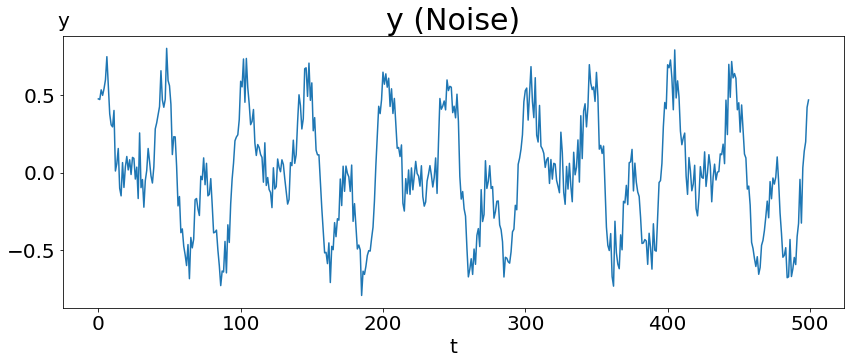

In [97]:
wave_size = 500
t, wave = toy_func(tStop=wave_size, triAmpl=1./4, tAmpl=0.0, noiseAmpl=0.1)

fig = plt.figure(figsize=(14,5))  # (width, height)
ax = fig.add_subplot(1,1,1)
ax.plot(t, wave)

title = "y (Noise)"
ax.set_title(label=title, fontsize=30)
ax.set_xlabel(xlabel="t", fontsize=20)
ax.set_ylabel(ylabel="y", fontsize=20, rotation=0)
ax.yaxis.set_label_coords(x=0.0, y=1.02)
ax.tick_params(labelsize=20)

plt.show()

In [98]:
input_arr = np.empty(shape=(0, windowsize))
print(input_arr.shape)
for i in range( wave.shape[0] - (windowsize + predictsize) + 1 ):
    input_arr = np.append(arr=input_arr,
                           values=wave[i:(i+windowsize)].reshape(1, -1),
                           axis=0)
print("input_arr.shape  : ", input_arr.shape)
input_arr = input_arr.reshape((-1, windowsize, 1))
print("input_arr.shape  : ", input_arr.shape)

(0, 60)
input_arr.shape  :  (440, 60)
input_arr.shape  :  (440, 60, 1)


## Load Model

In [99]:
from keras.models import load_model

In [100]:
modelpath = str(keras_model_h5_Path / "model__create_Conv1d_model__SinCosFunc.h5")
model = load_model(filepath=modelpath)

In [101]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 60, 60)            660       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 30, 60)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 30, 60)            36060     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 6, 60)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 6, 30)             18030     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 1, 30)             0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 1, 15)             4515      
__________

## Visualize conv1d_1 Outputs

In [102]:
from keras.models import Model
output_layer_name = 'conv1d_1'
hidden_layer_model = Model(inputs=model.input,
                           outputs=model.get_layer(output_layer_name).output)

In [103]:
hidden_layer_output = hidden_layer_model.predict(x=input_arr)
print(hidden_layer_output.shape)

(440, 60, 60)


### Ch00 [0-59]

#### plot

In [104]:
ch = 0

In [105]:
#--------------------
# Resize
#--------------------
weights = hidden_layer_output[:, :, ch].squeeze()
print(weights.shape)
weights = weights.T
print(weights.shape)

(440, 60)
(60, 440)


In [106]:
#--------------------
# get max value for plot Color
#--------------------
print("max : ", np.max(weights))
print("min : ", np.min(weights))
max_abs = np.maximum(np.max(weights),
                     abs(np.min(weights))
                    )
print("max abs : ", max_abs)

max :  0.4989405
min :  0.0
max abs :  0.4989405


(-0.5, 439.5)
(59.5, -0.5)
1.222222222222222


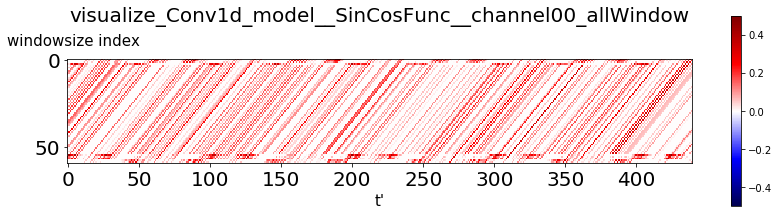

In [107]:
#--------------------------------------------------------------------------------
# Setting Parameter
#--------------------------------------------------------------------------------
title = ipynb_title + "__" + "channel00_allWindow"
filename = title + ".png"

#--------------------------------------------------------------------------------
# Plot
#--------------------------------------------------------------------------------
figsize=(14, 7)
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(1,1,1)
mappable = ax.imshow(weights,
                     cmap='seismic',  # <-- (min,max)=(blue, red)
                     vmin=-max_abs,
                     vmax=max_abs,
                     )
fig.colorbar(mappable,
             ax=ax,
             #orientation='horizontal',
             orientation='vertical',
             shrink=0.5,
             )

#----------------------------------------
# change x,y axis ratio
#----------------------------------------
# height is aspect_num times the width
print(ax.get_xlim())
print(ax.get_ylim())
xratio = 6
aspect = (1/xratio) * (ax.get_xlim()[1] - ax.get_xlim()[0]) / (ax.get_ylim()[0] - ax.get_ylim()[1])
print(aspect)
ax.set_aspect(aspect=aspect,)

#----------------------------------------
# plot config
#----------------------------------------
ax.set_title(label=title, fontsize=20, y=1.3)
ax.set_xlabel(xlabel="t'", fontsize=15)
ax.set_ylabel(ylabel="windowsize index", fontsize=15, rotation=0)
ax.yaxis.set_label_coords(x=0.01, y=1.1)  # ylabel position
ax.tick_params(labelsize=20)  # tick fontsize

fig.savefig(fname=str(plot_image_Path / filename))
plt.show()

#### Convolve Output
出力を畳み込むとはどういうことか.

<img src="./images/fig01.png">

In [108]:
figsize = (25, 10)
cmap = "seismic"

In [109]:
#--------------------------------------------------------------------------------
# Setting Parameter
#--------------------------------------------------------------------------------
title = ipynb_title + "__channel00__convolveWindows"
filename = title + ".png"

In [110]:
#----------------------------------------
# Convolved window size
#----------------------------------------
weights_tmp = hidden_layer_output[:, :, ch].squeeze()
weights_tmp = weights_tmp.T

# Prepare for convolved
weights = np.empty(shape=(0, wave_size - predictsize))
for window_idx in range(windowsize):
    _shape = weights_tmp.shape[1]
    # append last
    if window_idx < windowsize-1:
        _val = weights_tmp[-1, -windowsize+window_idx+1:]
        insert_arr = np.append(arr=weights_tmp[window_idx],
                               values=_val,
                               axis=None)
    else:
        insert_arr = weights_tmp[window_idx]

    # insert first
    _val = weights_tmp[0, :window_idx]
    insert_arr = np.insert(arr=insert_arr,
                           obj   =[0 for i in range(window_idx)],
                           values=_val,
                           ).reshape(1, -1)
    # append to the array
    #print(insert_arr.shape)
    weights = np.append(
        arr=weights,
        values=insert_arr,
        axis=0,
    )
print("weights.shape : ", weights.shape)

weights.shape :  (60, 499)


In [111]:
# Convolved
weights_convolve_windows = weights.sum(axis=0).reshape(1, -1)
print("weights_convolve_windows.shape : ", weights_convolve_windows.shape)

weights_convolve_windows.shape :  (1, 499)


In [112]:
#--------------------
# get max value for plot Color
#--------------------
print("max : ", np.max(weights_convolve_windows))
print("min : ", np.min(weights_convolve_windows))
max_abs = np.maximum(np.max(weights_convolve_windows),
                     abs(np.min(weights_convolve_windows))
                    )
print("max abs : ", max_abs)

max :  18.38624749146402
min :  0.0
max abs :  18.38624749146402


#### plot

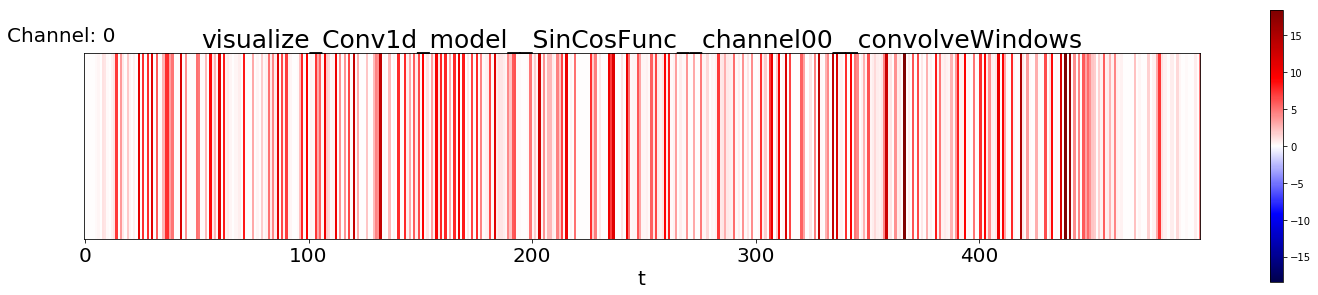

In [113]:
#--------------------------------------------------------------------------------
# Plot
#--------------------------------------------------------------------------------
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(1,1,1)
mappable = ax.imshow(weights_convolve_windows,
                     cmap='seismic',  # <-- (min,max)=(blue, red)
                     vmin=-max_abs,
                     vmax=max_abs,
                     )
fig.colorbar(mappable,
             ax=ax,
             orientation='vertical',
             shrink=0.5,
             )

#----------------------------------------
# change x,y axis ratio
#----------------------------------------
# height is aspect_num times the width
xratio = 6
aspect = (1/xratio) * (ax.get_xlim()[1] - ax.get_xlim()[0]) / (ax.get_ylim()[0] - ax.get_ylim()[1])
ax.set_aspect(aspect=aspect,)

#----------------------------------------
# plot config
#----------------------------------------
ax.set_title(label=title, fontsize=25)
ax.set_xlabel(xlabel="t", fontsize=20)
ax.set_ylabel(ylabel="Channel: {}".format(ch), fontsize=20, rotation=0)
ax.yaxis.set_label_coords(x=-0.02, y=1.04)
ax.tick_params(labelsize=20)
ax.tick_params(axis ='y',        # changes apply to the x-axis
               which="both",     # both major and minor ticks are affected
               left =False,      # ticks along the bottom edge are off
               labelleft=False)  # labels along the bottom edge are off
               # ref: https://stackoverflow.com/questions/12998430/remove-xticks-in-a-matplotlib-plot    
                                        
                                        

fig.savefig(fname=str(plot_image_Path / filename))
plt.show()

#### 元波形との重ねあわせ

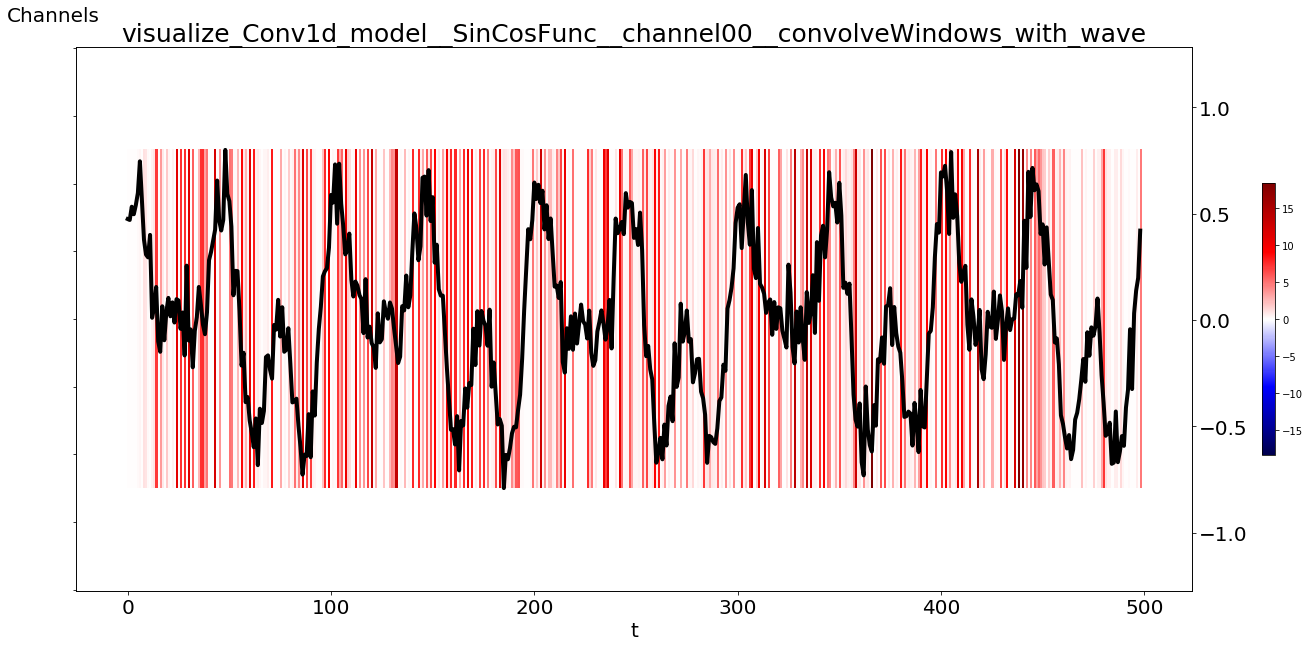

In [114]:
#--------------------------------------------------------------------------------
# Setting Parameter
#--------------------------------------------------------------------------------
title = ipynb_title + "__channel00__convolveWindows_with_wave"
filename = title + ".png"

figsize = (25, 10)
cmap = "seismic"

#--------------------------------------------------------------------------------
# Plot
#--------------------------------------------------------------------------------
fig = plt.figure(figsize=figsize)

#------------------------------------------------------------
# weights
#------------------------------------------------------------
ax1 = fig.add_subplot(1,1,1)
mappable = ax1.imshow(weights_convolve_windows,
                      cmap='seismic',  # <-- (min,max)=(blue, red)
                      vmin=-max_abs,
                      vmax=max_abs,
                      )
fig.colorbar(mappable,
             ax=ax1,
             orientation='vertical',
             shrink=0.5,
             )

#----------------------------------------
# change x,y axis ratio
#----------------------------------------
# ref:
#   - http://yama-sampo.hatenablog.com/entry/2017/12/21/195519
xratio = 3  # <width> / <height>
aspect = (1/xratio) * (ax1.get_xlim()[1] - ax1.get_xlim()[0]) / (ax1.get_ylim()[0] - ax1.get_ylim()[1])
ax1.set_aspect(aspect=aspect,)  # <height> = <aspect_num> x <width>

#----------------------------------------
# plot config
#----------------------------------------
## title & axis labels
ax1.set_title(label=title, fontsize=25)
ax1.set_xlabel(xlabel="t", fontsize=20)
ax1.set_ylabel(ylabel="Channels", fontsize=20, rotation=0)
ax1.yaxis.set_label_coords(x=-0.02, y=1.04)
## ticks
ax1.tick_params(labelsize=20)
## y ticks
ax1.tick_params(axis ='y',        # changes apply to the x-axis
               which="both",     # both major and minor ticks are affected
               left =False,      # ticks along the bottom edge are off
               labelleft=False)  # labels along the bottom edge are off
               # ref: https://stackoverflow.com/questions/12998430/remove-xticks-in-a-matplotlib-plot    

#------------------------------------------------------------
# wave
#------------------------------------------------------------
ax2 = ax1.twinx()
ax2.yaxis.tick_right()                          # y軸を右に指定
ax2.yaxis.set_label_position(position="right")  # y軸のラベルを右に指定
ax2.plot(np.arange(wave_size - predictsize), wave[:wave_size - predictsize],
         linewidth="4", color="black")
#----------------------------------------
# plot config
#----------------------------------------
## title & axis labels
ax2.tick_params(labelsize=20)

xratio = 3  # <width> / <height>
aspect = (1/xratio) * (ax2.get_xlim()[1] - ax2.get_xlim()[0]) / (ax2.get_ylim()[0] - ax2.get_ylim()[1])
ax2.set_aspect(aspect=aspect,)  # <height> = <aspect_num> x <width>


fig.savefig(fname=str(plot_image_Path / filename))
plt.show()

##### 考察
上のグラフを見ると波形の急激な __下降__ 時に畳み込み層の出力が大きな値を示していることがわかります。

### All Ch [0-59]

In [115]:
#------------------------------------------------------------
# Convolve all channels
#------------------------------------------------------------
weights_convolve_windows_all_channels = np.empty(shape=(0, wave_size - predictsize))
channel_size = hidden_layer_output.shape[2]
for ch in range(channel_size):
    #----------------------------------------
    # Convolved window size
    #----------------------------------------
    weights_tmp = hidden_layer_output[:, :, ch].squeeze()
    weights_tmp = weights_tmp.T

    # Prepare for convolved
    weights = np.empty(shape=(0, wave_size-1))
    for window_idx in range(windowsize):
        _shape = weights_tmp.shape[1]
        # append last
        if window_idx < windowsize-1:
            _val = weights_tmp[-1, -windowsize+window_idx+1:]
            insert_arr = np.append(arr=weights_tmp[window_idx],
                                   values=_val,
                                   axis=None)
        else:
            insert_arr = weights_tmp[window_idx]

        # insert first
        _val = weights_tmp[0, :window_idx]
        insert_arr = np.insert(arr=insert_arr,
                               obj   =[0 for i in range(window_idx)],
                               values=_val,
                               ).reshape(1, -1)
        # append to the array
        #print(insert_arr.shape)
        weights = np.append(
            arr=weights,
            values=insert_arr,
            axis=0,
        )

    # Convolved
    weights_convolve_windows = weights.sum(axis=0).reshape(1, -1)

    # Append
    weights_convolve_windows_all_channels = \
        np.append(arr   =weights_convolve_windows_all_channels,
                  values=weights_convolve_windows,
                  axis  =0)
print("weights_convolve_windows_all_channels.shape : ", weights_convolve_windows_all_channels.shape)

weights_convolve_windows_all_channels.shape :  (60, 499)


In [116]:
#--------------------
# get max value for plot Color
#--------------------
print("max : ", np.max(weights_convolve_windows_all_channels))
print("min : ", np.min(weights_convolve_windows_all_channels))
max_abs = np.maximum(np.max(weights_convolve_windows_all_channels),
                     abs(np.min(weights_convolve_windows_all_channels))
                    )
print("max abs : ", max_abs)

max :  23.58817657828331
min :  0.0
max abs :  23.58817657828331


#### plot

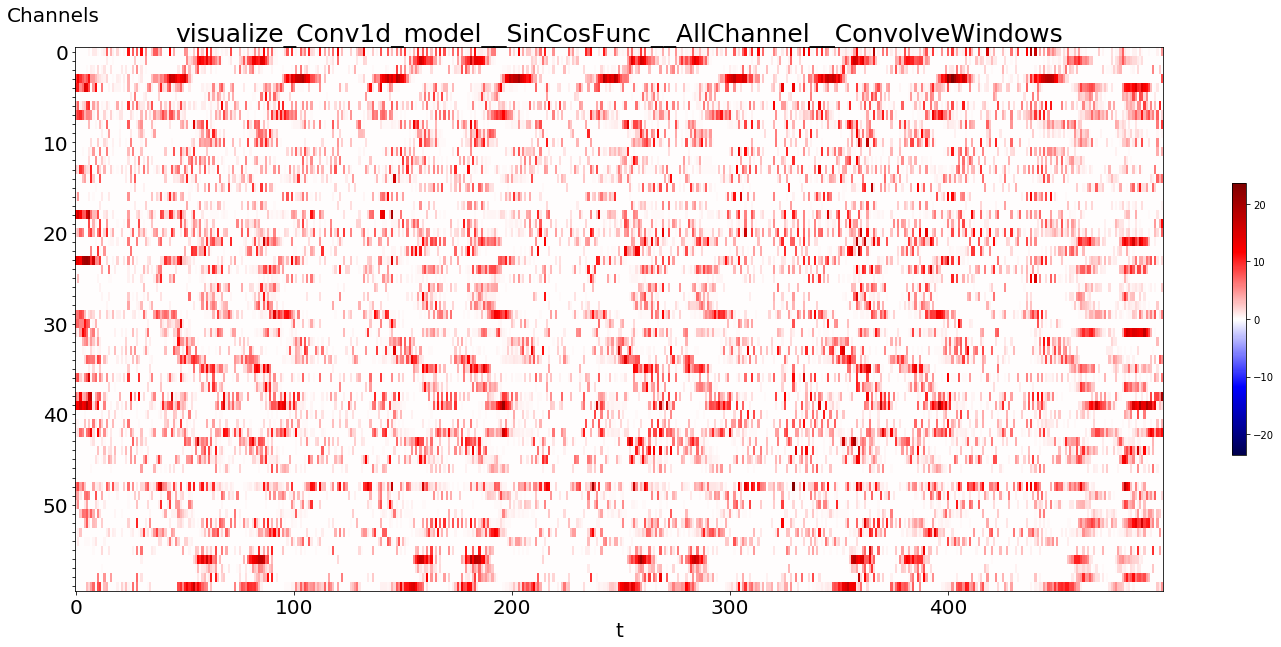

In [117]:
#--------------------------------------------------------------------------------
# Setting Parameter
#--------------------------------------------------------------------------------
title = ipynb_title + "__AllChannel__ConvolveWindows"
filename = title + ".png"

figsize = (25, 10)
cmap = "seismic"

#--------------------------------------------------------------------------------
# Plot
#--------------------------------------------------------------------------------
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(1,1,1)
mappable = ax.imshow(weights_convolve_windows_all_channels,
                     cmap='seismic',  # <-- (min,max)=(blue, red)
                     vmin=-max_abs,
                     vmax=max_abs,
                     )
fig.colorbar(mappable,
             ax=ax,
             orientation='vertical',
             shrink=0.5,
             )

#----------------------------------------
# change x,y axis ratio
#----------------------------------------
# ref:
#   - http://yama-sampo.hatenablog.com/entry/2017/12/21/195519
xratio = 2  # <width> / <height>
aspect = (1/xratio) * (ax.get_xlim()[1] - ax.get_xlim()[0]) / (ax.get_ylim()[0] - ax.get_ylim()[1])
ax.set_aspect(aspect=aspect,)  # <height> = <aspect_num> x <width>

#----------------------------------------
# plot config
#----------------------------------------
## title & axis labels
ax.set_title(label=title, fontsize=25)
ax.set_xlabel(xlabel="t", fontsize=20)
ax.set_ylabel(ylabel="Channels", fontsize=20, rotation=0)
ax.yaxis.set_label_coords(x=-0.02, y=1.04)
## ticks
ax.tick_params(labelsize=20)
## y ticks
ax.set_yticks(ticks=np.arange(channel_size))
ax.set_yticklabels(labels=[i if i%10==0 else "" for i in range(channel_size)])

fig.savefig(fname=str(plot_image_Path / filename))
plt.show()

#### 元波形との重ねあわせ

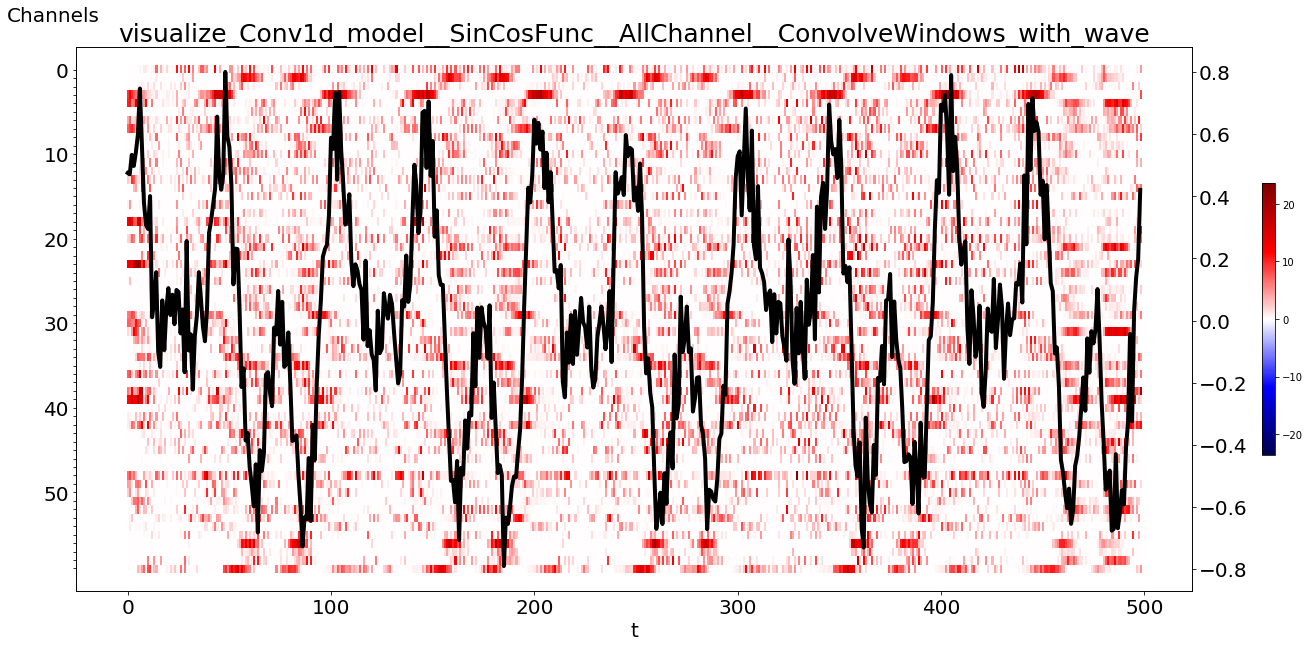

In [118]:
#--------------------------------------------------------------------------------
# Setting Parameter
#--------------------------------------------------------------------------------
title = ipynb_title + "__AllChannel__ConvolveWindows_with_wave"
filename = title + ".png"

figsize = (25, 10)
cmap = "seismic"

#--------------------------------------------------------------------------------
# Plot
#--------------------------------------------------------------------------------
fig = plt.figure(figsize=figsize)

#------------------------------------------------------------
# weights
#------------------------------------------------------------
ax1 = fig.add_subplot(1,1,1)
mappable = ax1.imshow(weights_convolve_windows_all_channels,
                      cmap='seismic',  # <-- (min,max)=(blue, red)
                      vmin=-max_abs,
                      vmax=max_abs,
                      )
fig.colorbar(mappable,
             ax=ax1,
             orientation='vertical',
             shrink=0.5,
             )

#----------------------------------------
# change x,y axis ratio
#----------------------------------------
# ref:
#   - http://yama-sampo.hatenablog.com/entry/2017/12/21/195519
xratio = 2  # <width> / <height>
aspect = (1/xratio) * (ax1.get_xlim()[1] - ax1.get_xlim()[0]) / (ax1.get_ylim()[0] - ax1.get_ylim()[1])
ax1.set_aspect(aspect=aspect,)  # <height> = <aspect_num> x <width>

#----------------------------------------
# plot config
#----------------------------------------
## title & axis labels
ax1.set_title(label=title, fontsize=25)
ax1.set_xlabel(xlabel="t", fontsize=20)
ax1.set_ylabel(ylabel="Channels", fontsize=20, rotation=0)
ax1.yaxis.set_label_coords(x=-0.02, y=1.04)
## ticks
ax1.tick_params(labelsize=20)
## y ticks
ax1.set_yticks(ticks=np.arange(channel_size))
ax1.set_yticklabels(labels=[i if i%10==0 else "" for i in range(channel_size)])

#------------------------------------------------------------
# wave
#------------------------------------------------------------
ax2 = ax1.twinx()
ax2.yaxis.tick_right()                          # y軸を右に指定
ax2.yaxis.set_label_position(position="right")  # y軸のラベルを右に指定
ax2.plot(np.arange(wave_size - predictsize), wave[:wave_size - predictsize],
         linewidth=4, color="black")
ax2.tick_params(labelsize=20)

fig.savefig(fname=str(plot_image_Path / filename))
plt.show()

##### 考察
上の図はすべてのチャネルの出力を表示しているのでドット表現のような感じです。
全体としては少々見づらいですが, __波の上昇や下降などの特徴をどのチャネルが捉えているのか__ を俯瞰するために役立ちます.

また,
```
fig = plt.figure(figsize=(width, height))
```
の`width`と`height`を大きな値に指定してやれば解像度の高い画像が得られるので,どのチャンネルかを確かめる際にはこの値を変えるといいと思います.

## 特徴をつかむ

全体図から上昇や下降している箇所で出力値の高い値を取得してチャネルごとに表示してみます.

- 波形の上昇を取得 (Ch29 [0-59])
- 波形の下降時の特徴を取得 (Ch32 [0-59])

### 波形の上昇を取得 (Ch29 [0-59])

#### plot

In [119]:
ch = 29

(440, 60)
(60, 440)
max :  0.2914392
min :  0.0
max abs :  0.2914392
(-0.5, 439.5)
(59.5, -0.5)
1.222222222222222


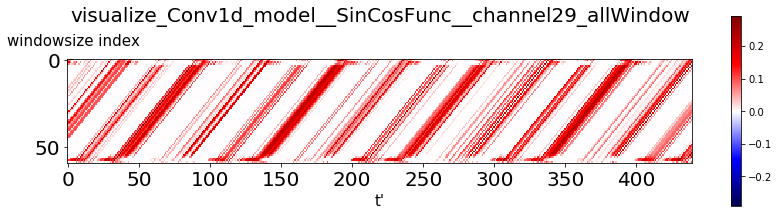

In [120]:
#--------------------
# Resize
#--------------------
weights = hidden_layer_output[:, :, ch].squeeze()
print(weights.shape)
weights = weights.T
print(weights.shape)

#--------------------
# get max value for plot Color
#--------------------
print("max : ", np.max(weights))
print("min : ", np.min(weights))
max_abs = np.maximum(np.max(weights),
                     abs(np.min(weights))
                    )
print("max abs : ", max_abs)

#--------------------------------------------------------------------------------
# Setting Parameter
#--------------------------------------------------------------------------------
title = ipynb_title + "__" + "channel{}_allWindow".format(ch)
filename = title + ".png"

#--------------------------------------------------------------------------------
# Plot
#--------------------------------------------------------------------------------
figsize=(14, 7)
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(1,1,1)
mappable = ax.imshow(weights,
                     cmap='seismic',  # <-- (min,max)=(blue, red)
                     vmin=-max_abs,
                     vmax=max_abs,
                     )
fig.colorbar(mappable,
             ax=ax,
             #orientation='horizontal',
             orientation='vertical',
             shrink=0.5,
             )

#----------------------------------------
# change x,y axis ratio
#----------------------------------------
# height is aspect_num times the width
print(ax.get_xlim())
print(ax.get_ylim())
xratio = 6
aspect = (1/xratio) * (ax.get_xlim()[1] - ax.get_xlim()[0]) / (ax.get_ylim()[0] - ax.get_ylim()[1])
print(aspect)
ax.set_aspect(aspect=aspect,)

#----------------------------------------
# plot config
#----------------------------------------
ax.set_title(label=title, fontsize=20, y=1.3)
ax.set_xlabel(xlabel="t'", fontsize=15)
ax.set_ylabel(ylabel="windowsize index", fontsize=15, rotation=0)
ax.yaxis.set_label_coords(x=0.01, y=1.1)  # ylabel position
ax.tick_params(labelsize=20)  # tick fontsize

fig.savefig(fname=str(plot_image_Path / filename))
plt.show()

#### Convolve Output

In [121]:
#----------------------------------------
# Convolved window size
#----------------------------------------
weights_tmp = hidden_layer_output[:, :, ch].squeeze()
weights_tmp = weights_tmp.T

# Prepare for convolved
weights = np.empty(shape=(0, wave_size - predictsize))
for window_idx in range(windowsize):
    _shape = weights_tmp.shape[1]
    # append last
    if window_idx < windowsize-1:
        _val = weights_tmp[-1, -windowsize+window_idx+1:]
        insert_arr = np.append(arr=weights_tmp[window_idx],
                               values=_val,
                               axis=None)
    else:
        insert_arr = weights_tmp[window_idx]

    # insert first
    _val = weights_tmp[0, :window_idx]
    insert_arr = np.insert(arr=insert_arr,
                           obj   =[0 for i in range(window_idx)],
                           values=_val,
                           ).reshape(1, -1)
    # append to the array
    #print(insert_arr.shape)
    weights = np.append(
        arr=weights,
        values=insert_arr,
        axis=0,
    )
print("weights.shape : ", weights.shape)

# Convolved
weights_convolve_windows = weights.sum(axis=0).reshape(1, -1)
print("weights_convolve_windows.shape : ", weights_convolve_windows.shape)

#--------------------
# get max value for plot Color
#--------------------
print("max : ", np.max(weights_convolve_windows))
print("min : ", np.min(weights_convolve_windows))
max_abs = np.maximum(np.max(weights_convolve_windows),
                     abs(np.min(weights_convolve_windows))
                    )
print("max abs : ", max_abs)

weights.shape :  (60, 499)
weights_convolve_windows.shape :  (1, 499)
max :  14.666657470166683
min :  0.0
max abs :  14.666657470166683


#### plot

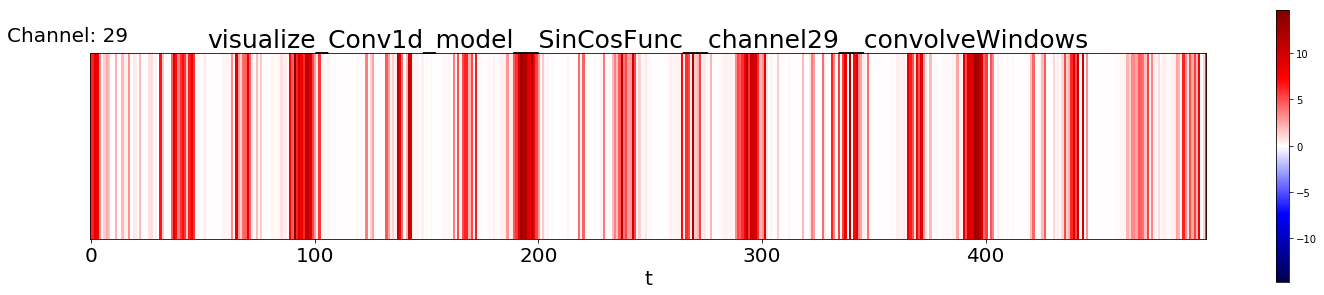

In [122]:
#--------------------------------------------------------------------------------
# Setting Parameter
#--------------------------------------------------------------------------------
title = ipynb_title + "__channel{}__convolveWindows".format(ch)
filename = title + ".png"

figsize = (25, 10)
cmap = "seismic"

#--------------------------------------------------------------------------------
# Plot
#--------------------------------------------------------------------------------
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(1,1,1)
mappable = ax.imshow(weights_convolve_windows,
                     cmap='seismic',  # <-- (min,max)=(blue, red)
                     vmin=-max_abs,
                     vmax=max_abs,
                     )
fig.colorbar(mappable,
             ax=ax,
             orientation='vertical',
             shrink=0.5,
             )

#----------------------------------------
# change x,y axis ratio
#----------------------------------------
# height is aspect_num times the width
xratio = 6
aspect = (1/xratio) * (ax.get_xlim()[1] - ax.get_xlim()[0]) / (ax.get_ylim()[0] - ax.get_ylim()[1])
ax.set_aspect(aspect=aspect,)

#----------------------------------------
# plot config
#----------------------------------------
ax.set_title(label=title, fontsize=25)
ax.set_xlabel(xlabel="t", fontsize=20)
ax.set_ylabel(ylabel="Channel: {}".format(ch), fontsize=20, rotation=0)
ax.yaxis.set_label_coords(x=-0.02, y=1.04)
ax.tick_params(labelsize=20)
ax.tick_params(axis ='y',        # changes apply to the x-axis
               which="both",     # both major and minor ticks are affected
               left =False,      # ticks along the bottom edge are off
               labelleft=False)  # labels along the bottom edge are off
               # ref: https://stackoverflow.com/questions/12998430/remove-xticks-in-a-matplotlib-plot    
                                        
                                        

fig.savefig(fname=str(plot_image_Path / filename))
plt.show()

#### 元波形との重ねあわせ

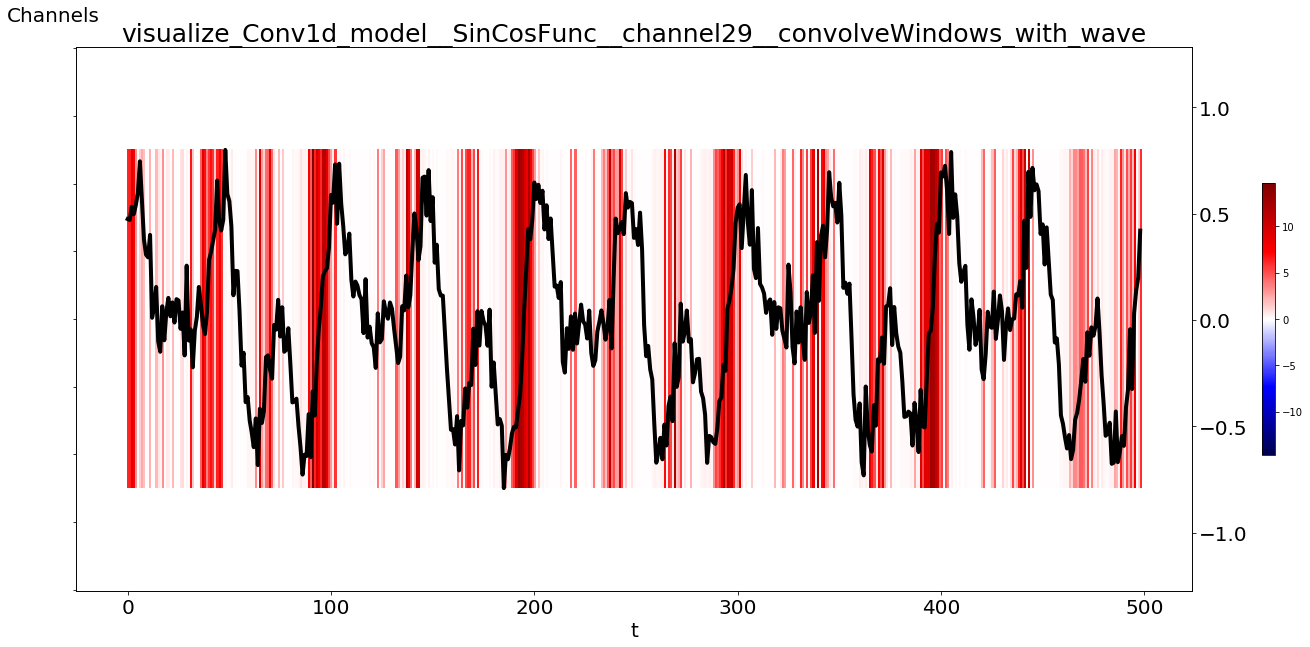

In [123]:
#--------------------------------------------------------------------------------
# Setting Parameter
#--------------------------------------------------------------------------------
title = ipynb_title + "__channel{}__convolveWindows_with_wave".format(ch)
filename = title + ".png"

figsize = (25, 10)
cmap = "seismic"

#--------------------------------------------------------------------------------
# Plot
#--------------------------------------------------------------------------------
fig = plt.figure(figsize=figsize)

#------------------------------------------------------------
# weights
#------------------------------------------------------------
ax1 = fig.add_subplot(1,1,1)
mappable = ax1.imshow(weights_convolve_windows,
                      cmap='seismic',  # <-- (min,max)=(blue, red)
                      vmin=-max_abs,
                      vmax=max_abs,
                      )
fig.colorbar(mappable,
             ax=ax1,
             orientation='vertical',
             shrink=0.5,
             )

#----------------------------------------
# change x,y axis ratio
#----------------------------------------
# ref:
#   - http://yama-sampo.hatenablog.com/entry/2017/12/21/195519
xratio = 3  # <width> / <height>
aspect = (1/xratio) * (ax1.get_xlim()[1] - ax1.get_xlim()[0]) / (ax1.get_ylim()[0] - ax1.get_ylim()[1])
ax1.set_aspect(aspect=aspect,)  # <height> = <aspect_num> x <width>

#----------------------------------------
# plot config
#----------------------------------------
## title & axis labels
ax1.set_title(label=title, fontsize=25)
ax1.set_xlabel(xlabel="t", fontsize=20)
ax1.set_ylabel(ylabel="Channels", fontsize=20, rotation=0)
ax1.yaxis.set_label_coords(x=-0.02, y=1.04)
## ticks
ax1.tick_params(labelsize=20)
## y ticks
ax1.tick_params(axis ='y',        # changes apply to the x-axis
               which="both",     # both major and minor ticks are affected
               left =False,      # ticks along the bottom edge are off
               labelleft=False)  # labels along the bottom edge are off
               # ref: https://stackoverflow.com/questions/12998430/remove-xticks-in-a-matplotlib-plot    

#------------------------------------------------------------
# wave
#------------------------------------------------------------
ax2 = ax1.twinx()
ax2.yaxis.tick_right()                          # y軸を右に指定
ax2.yaxis.set_label_position(position="right")  # y軸のラベルを右に指定
ax2.plot(np.arange(wave_size - predictsize), wave[:wave_size - predictsize],
         linewidth="4", color="black")
#----------------------------------------
# plot config
#----------------------------------------
## title & axis labels
ax2.tick_params(labelsize=20)

xratio = 3  # <width> / <height>
aspect = (1/xratio) * (ax2.get_xlim()[1] - ax2.get_xlim()[0]) / (ax2.get_ylim()[0] - ax2.get_ylim()[1])
ax2.set_aspect(aspect=aspect,)  # <height> = <aspect_num> x <width>


fig.savefig(fname=str(plot_image_Path / filename))
plt.show()

##### 考察
上のグラフを見ると波形の急激な __上昇__ 時に畳み込み層の出力が大きな値を示していることがわかります。

### 波形の下降を取得 (Ch32 [0-59])

#### plot

In [124]:
ch = 32

(440, 60)
(60, 440)
max :  0.29079962
min :  0.0
max abs :  0.29079962
(-0.5, 439.5)
(59.5, -0.5)
1.222222222222222


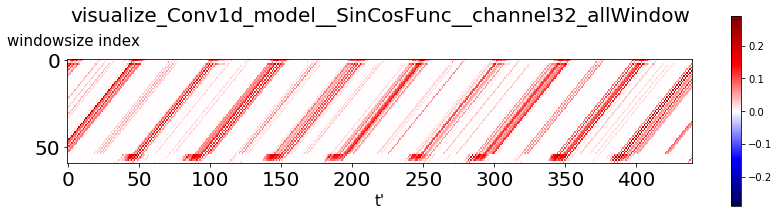

In [125]:
#--------------------
# Resize
#--------------------
weights = hidden_layer_output[:, :, ch].squeeze()
print(weights.shape)
weights = weights.T
print(weights.shape)

#--------------------
# get max value for plot Color
#--------------------
print("max : ", np.max(weights))
print("min : ", np.min(weights))
max_abs = np.maximum(np.max(weights),
                     abs(np.min(weights))
                    )
print("max abs : ", max_abs)

#--------------------------------------------------------------------------------
# Setting Parameter
#--------------------------------------------------------------------------------
title = ipynb_title + "__" + "channel{}_allWindow".format(ch)
filename = title + ".png"

#--------------------------------------------------------------------------------
# Plot
#--------------------------------------------------------------------------------
figsize=(14, 7)
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(1,1,1)
mappable = ax.imshow(weights,
                     cmap='seismic',  # <-- (min,max)=(blue, red)
                     vmin=-max_abs,
                     vmax=max_abs,
                     )
fig.colorbar(mappable,
             ax=ax,
             #orientation='horizontal',
             orientation='vertical',
             shrink=0.5,
             )

#----------------------------------------
# change x,y axis ratio
#----------------------------------------
# height is aspect_num times the width
print(ax.get_xlim())
print(ax.get_ylim())
xratio = 6
aspect = (1/xratio) * (ax.get_xlim()[1] - ax.get_xlim()[0]) / (ax.get_ylim()[0] - ax.get_ylim()[1])
print(aspect)
ax.set_aspect(aspect=aspect,)

#----------------------------------------
# plot config
#----------------------------------------
ax.set_title(label=title, fontsize=20, y=1.3)
ax.set_xlabel(xlabel="t'", fontsize=15)
ax.set_ylabel(ylabel="windowsize index", fontsize=15, rotation=0)
ax.yaxis.set_label_coords(x=0.01, y=1.1)  # ylabel position
ax.tick_params(labelsize=20)  # tick fontsize

fig.savefig(fname=str(plot_image_Path / filename))
plt.show()

#### Convolve Output

In [126]:
#----------------------------------------
# Convolved window size
#----------------------------------------
weights_tmp = hidden_layer_output[:, :, ch].squeeze()
weights_tmp = weights_tmp.T

# Prepare for convolved
weights = np.empty(shape=(0, wave_size - predictsize))
for window_idx in range(windowsize):
    _shape = weights_tmp.shape[1]
    # append last
    if window_idx < windowsize-1:
        _val = weights_tmp[-1, -windowsize+window_idx+1:]
        insert_arr = np.append(arr=weights_tmp[window_idx],
                               values=_val,
                               axis=None)
    else:
        insert_arr = weights_tmp[window_idx]

    # insert first
    _val = weights_tmp[0, :window_idx]
    insert_arr = np.insert(arr=insert_arr,
                           obj   =[0 for i in range(window_idx)],
                           values=_val,
                           ).reshape(1, -1)
    # append to the array
    #print(insert_arr.shape)
    weights = np.append(
        arr=weights,
        values=insert_arr,
        axis=0,
    )
print("weights.shape : ", weights.shape)

# Convolved
weights_convolve_windows = weights.sum(axis=0).reshape(1, -1)
print("weights_convolve_windows.shape : ", weights_convolve_windows.shape)

#--------------------
# get max value for plot ylim
#--------------------
print("max : ", np.max(weights_convolve_windows))
print("min : ", np.min(weights_convolve_windows))
max_abs = np.maximum(np.max(weights_convolve_windows),
                     abs(np.min(weights_convolve_windows))
                    )
print("max abs : ", max_abs)

weights.shape :  (60, 499)
weights_convolve_windows.shape :  (1, 499)
max :  11.603520967066288
min :  0.0
max abs :  11.603520967066288


#### plot

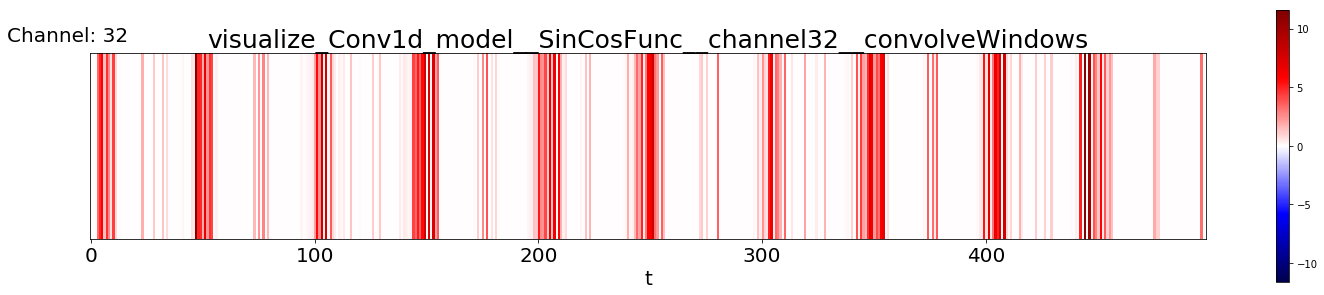

In [127]:
#--------------------------------------------------------------------------------
# Setting Parameter
#--------------------------------------------------------------------------------
title = ipynb_title + "__channel{}__convolveWindows".format(ch)
filename = title + ".png"

figsize = (25, 10)
cmap = "seismic"

#--------------------------------------------------------------------------------
# Plot
#--------------------------------------------------------------------------------
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(1,1,1)
mappable = ax.imshow(weights_convolve_windows,
                     cmap='seismic',  # <-- (min,max)=(blue, red)
                     vmin=-max_abs,
                     vmax=max_abs,
                     )
fig.colorbar(mappable,
             ax=ax,
             orientation='vertical',
             shrink=0.5,
             )

#----------------------------------------
# change x,y axis ratio
#----------------------------------------
# height is aspect_num times the width
xratio = 6
aspect = (1/xratio) * (ax.get_xlim()[1] - ax.get_xlim()[0]) / (ax.get_ylim()[0] - ax.get_ylim()[1])
ax.set_aspect(aspect=aspect,)

#----------------------------------------
# plot config
#----------------------------------------
ax.set_title(label=title, fontsize=25)
ax.set_xlabel(xlabel="t", fontsize=20)
ax.set_ylabel(ylabel="Channel: {}".format(ch), fontsize=20, rotation=0)
ax.yaxis.set_label_coords(x=-0.02, y=1.04)
ax.tick_params(labelsize=20)
ax.tick_params(axis ='y',        # changes apply to the x-axis
               which="both",     # both major and minor ticks are affected
               left =False,      # ticks along the bottom edge are off
               labelleft=False)  # labels along the bottom edge are off
               # ref: https://stackoverflow.com/questions/12998430/remove-xticks-in-a-matplotlib-plot    
                                        
                                        

fig.savefig(fname=str(plot_image_Path / filename))
plt.show()

#### 元波形との重ねあわせ

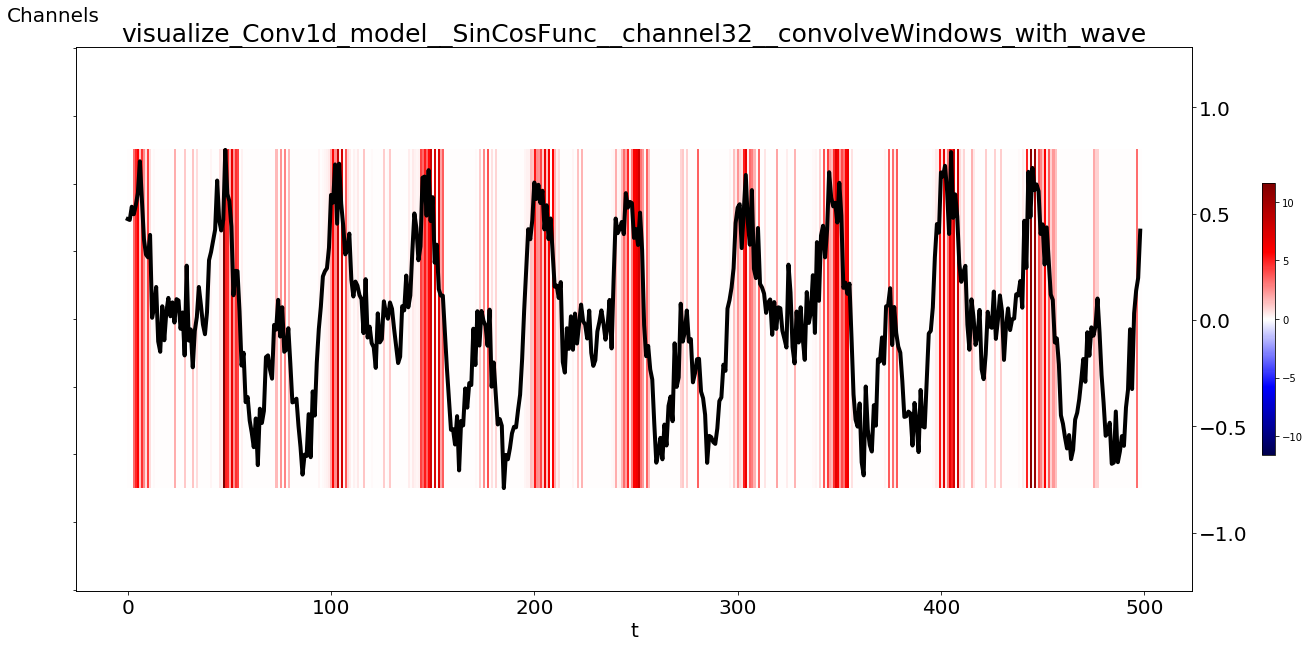

In [128]:
#--------------------------------------------------------------------------------
# Setting Parameter
#--------------------------------------------------------------------------------
title = ipynb_title + "__channel{}__convolveWindows_with_wave".format(ch)
filename = title + ".png"

figsize = (25, 10)
cmap = "seismic"

#--------------------------------------------------------------------------------
# Plot
#--------------------------------------------------------------------------------
fig = plt.figure(figsize=figsize)

#------------------------------------------------------------
# weights
#------------------------------------------------------------
ax1 = fig.add_subplot(1,1,1)
mappable = ax1.imshow(weights_convolve_windows,
                      cmap='seismic',  # <-- (min,max)=(blue, red)
                      vmin=-max_abs,
                      vmax=max_abs,
                      )
fig.colorbar(mappable,
             ax=ax1,
             orientation='vertical',
             shrink=0.5,
             )

#----------------------------------------
# change x,y axis ratio
#----------------------------------------
# ref:
#   - http://yama-sampo.hatenablog.com/entry/2017/12/21/195519
xratio = 3  # <width> / <height>
aspect = (1/xratio) * (ax1.get_xlim()[1] - ax1.get_xlim()[0]) / (ax1.get_ylim()[0] - ax1.get_ylim()[1])
ax1.set_aspect(aspect=aspect,)  # <height> = <aspect_num> x <width>

#----------------------------------------
# plot config
#----------------------------------------
## title & axis labels
ax1.set_title(label=title, fontsize=25)
ax1.set_xlabel(xlabel="t", fontsize=20)
ax1.set_ylabel(ylabel="Channels", fontsize=20, rotation=0)
ax1.yaxis.set_label_coords(x=-0.02, y=1.04)
## ticks
ax1.tick_params(labelsize=20)
## y ticks
ax1.tick_params(axis ='y',        # changes apply to the x-axis
               which="both",     # both major and minor ticks are affected
               left =False,      # ticks along the bottom edge are off
               labelleft=False)  # labels along the bottom edge are off
               # ref: https://stackoverflow.com/questions/12998430/remove-xticks-in-a-matplotlib-plot    

#------------------------------------------------------------
# wave
#------------------------------------------------------------
ax2 = ax1.twinx()
ax2.yaxis.tick_right()                          # y軸を右に指定
ax2.yaxis.set_label_position(position="right")  # y軸のラベルを右に指定
ax2.plot(np.arange(wave_size - predictsize), wave[:wave_size - predictsize],
         linewidth="4", color="black")
#----------------------------------------
# plot config
#----------------------------------------
## title & axis labels
ax2.tick_params(labelsize=20)

xratio = 3  # <width> / <height>
aspect = (1/xratio) * (ax2.get_xlim()[1] - ax2.get_xlim()[0]) / (ax2.get_ylim()[0] - ax2.get_ylim()[1])
ax2.set_aspect(aspect=aspect,)  # <height> = <aspect_num> x <width>


fig.savefig(fname=str(plot_image_Path / filename))
plt.show()

##### 考察
上のグラフを見ると波形の急激な __下降__ 時に畳み込み層の出力が大きな値を示していることがわかります。

## End